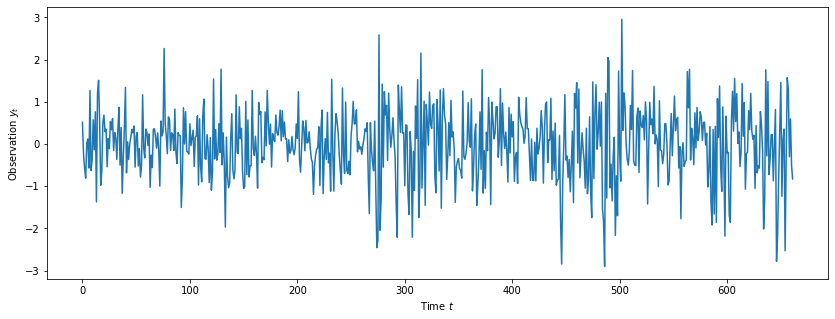

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, invgamma

# Load data
path = os.getcwd()
y = np.genfromtxt(path + '/OMXLogReturns.csv') 

# Plot observations
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(y)
ax.set_xlabel("Time $t$"); ax.set_ylabel("Observation $y_t$");
plt.show()

In [2]:
def bootstrap_particle_filter(y, N, theta, resampling=True):
    
    # Static parameters
    phi = theta[0] 
    sigma = theta[1] 
    beta = theta[2]
    
    # Initilialization
    T = len(y)
    logl = 0.0
    x = np.zeros([T+1, N])
    w = np.zeros([T+1, N])
    x[0, :] = np.random.normal(0.0, 1.0, size=N)
    w[0, :] = np.ones(N) / N
    
    for t in range(1, T+1):
        
        if resampling:
            x[t-1, :] = np.random.choice(x[t-1, :], N, p=w[t-1, :])
            
        x[t, :] = np.random.normal(loc=phi*x[t-1, :], scale=sigma, size=N)
        log_w_tilde = norm.logpdf(y[t-1], loc=0.0, scale=beta * np.exp(x[t,:] / 2) )
        
        # Compute log-liklihood with logsumexp trick
        max_w_tilde = np.max(log_w_tilde)
        log_w_tilde = log_w_tilde - max_w_tilde # subtract with maximum value of log weights
        logl += max_w_tilde + np.log(np.sum(np.exp(log_w_tilde))) - np.log(N)
        
        # normalize weights
        w[t, :] = np.exp(log_w_tilde) / np.sum(np.exp(log_w_tilde))                          
    return x, w, logl


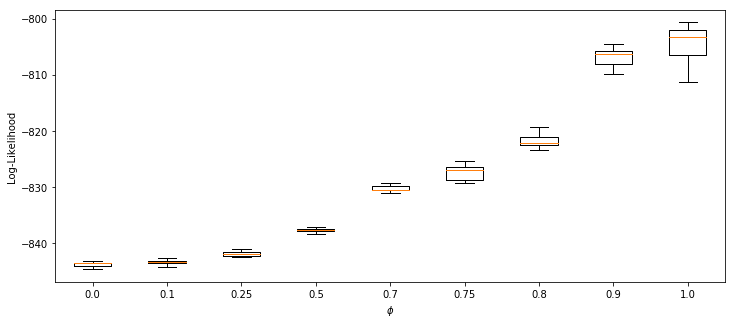

In [24]:
# Static parameters
Phi = [0.0, 0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.9, 1.0]
sigma = 0.16
beta = 0.7

n_runs = 10
logl_list = []
N = 100

for i, phi in enumerate(Phi):
    theta = [phi, sigma, beta]
    logl_phi = []
    for j in range(n_runs):
        x, w, logl = bootstrap_particle_filter(y, N, theta, resampling=True)
        logl_phi.append(logl)
    logl_list.append(logl_phi)

# Plot boxplot
phi_list = [str(phi) for phi in Phi]
fig, ax = plt.subplots(figsize=(12, 5))
ax.boxplot(logl_list, showfliers=False, labels=phi_list)
ax.set_xlabel(r"$\phi$"); ax.set_ylabel("Log-Likelihood"); 
plt.show()

In [31]:
def gaussian_random_walk(x, scale=1.0):
    return np.random.normal(loc=x, scale=scale)

def particle_metropolis_hastings(y, M=10000, N=20):
    
    logl = np.zeros(M)
    theta_proposed = np.zeros([M,2]) # store sigma2, beta2
    theta = np.zeros([M,2]) # store sigma2, beta2
    phi = 0.985 # constant
    
    # Initialization
    theta[0, 0] = 0.1 # sigma2
    theta[0, 1] = 1.0 # Beta2
    theta_proposed[0,:] = theta[0,:]
    params = [phi, np.sqrt(theta[0,0]), np.sqrt(theta[0,1])]
    _, _, logl_proposed = bootstrap_particle_filter(y, N, theta=params)
    logl[0] = logl_proposed

    count = 0
    for m in range(1, M):
        
        # Draw sample from proposal distribution
        # Note that sigma2 and beta2 has to be positive!
        # Accept proposed samples when both are positive
        notfound = True
        while notfound:
            theta_proposed[m, :] = gaussian_random_walk(theta[m-1, :])
            theta_proposed[m, :] = np.abs(theta_proposed[m,:])
            if theta_proposed[m, 0] > 0.0 and theta_proposed[m, 1] > 0.0:
                notfound = False
        
        # Sample from uniform distribution
        u = np.random.uniform(0.0, 1.0)
        
        # Run BPF to get loglikelihood estimate
        params = [phi, np.sqrt(theta_proposed[m,0]), np.sqrt(theta_proposed[m,1])] 
        _, _, logl_proposed = bootstrap_particle_filter(y, N, theta=params)
        
        # TODO: I receive runtime warning divide by zero in log somewhere!!!!
        # Using gaussian random walk as proposal q should cancel out
        # when computing acceptance probability alpha
        logl_difference = logl_proposed - logl[m-1]
        
        # Compute log prior difference
        #log_prior_sigma2 = np.log( invgamma_pdf(theta_proposed[m,0]) )
        # scale in scipy.stats.invgamma is b
        log_prior_sigma2 = invgamma.logpdf(x=theta_proposed[m,0], a=0.01, scale=0.01 )
        log_prior_sigma2 = log_prior_sigma2 - invgamma.logpdf(x=theta[m-1, 0], a=0.01, scale=0.01 )
        log_prior_beta2 = invgamma.logpdf(x=theta_proposed[m,1], a=0.01, scale=0.01) 
        log_prior_beta2 = log_prior_sigma2 - invgamma.logpdf(x=theta[m-1,1], a=0.01, scale=0.01 )
        log_prior = log_prior_sigma2 + log_prior_beta2
        
        #print("logl_difference: ", logl_difference)
        #print("log_prior: ", log_prior)
        #print("accept prob: ", np.exp(logl_difference + log_prior))
        alpha = np.minimum(1.0, np.exp(logl_difference + log_prior) )
        if u <= alpha:
            theta[m, :] = theta_proposed[m, :]
            logl[m] = logl_proposed
        else:
            theta[m, :] = theta[m-1, :]
            logl[m] = logl[m-1] 
        if (m%1000)==0:
            print("Number of samples ", m)
    return theta, logl

Number of samples  1000
Number of samples  2000
Number of samples  3000
Number of samples  4000


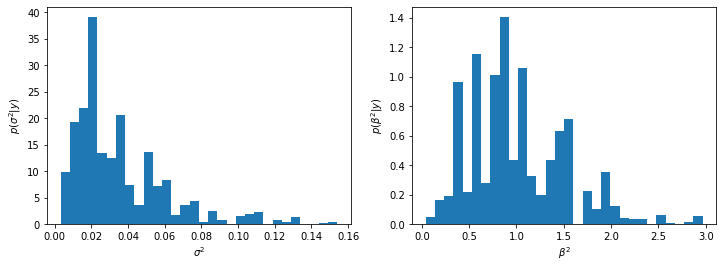

In [32]:
M = 5000 # number of samples from PMH
N = 100 # number of particles in BPF

theta, logl = particle_metropolis_hastings(y, M, N)

burnin = 1000
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].hist(theta[burnin:,0], bins=30, density=True)
ax[0].set_xlabel(r"$\sigma^2$"); ax[0].set_ylabel(r"$p(\sigma^2 | y)$");
ax[1].hist(theta[burnin:,1], bins=30, density=True)
ax[1].set_xlabel(r"$\beta^2$"); ax[1].set_ylabel(r"$p(\beta^2 | y)$");
plt.show()

In [73]:
def particle_gibbs_bpf(y, x_ref, N, theta):
    # Static parameters
    phi = theta[0] 
    sigma = theta[1] 
    beta = theta[2]
    
    # Initilialization
    T = len(y)
    x = np.zeros([T+1, N])
    w = np.zeros([T+1, N])
    x[0, :N-1] = np.random.normal(0.0, 1.0, size=N-1)
    x[0, N-1] = x_ref[0] # set final particle as x0 from reference trajectory
    w[0, :] = np.ones(N) / N
    ancs = np.zeros([T, N], dtype=int)
    
    for t in range(1, T+1):
        
        # TODO: Weights seem to explode somewhere here!
        ancs[t-1, :N-1] = np.random.choice(N, size=N-1, p=w[t-1, :])
        #x[t-1, :] = np.random.choice(x[t-1, :], N, p=w[t-1, :])
        
        #print(ancs)
        #print(x[t-1, ancs])
        x[t, :N-1] = np.random.normal(loc=phi*x[t-1, ancs[t-1, :N-1]], scale=sigma, size=N-1)
        x[t, -1] = x_ref[t]
        ancs[t-1, -1] = N
        
        log_w_tilde = norm.logpdf(y[t-1], loc=0.0, scale=beta * np.exp(x[t,:] / 2) )
        max_w_tilde = np.max(log_w_tilde)
        log_w_tilde = log_w_tilde - max_w_tilde # subtract with maximum value of log weights
        
        # normalize weights
        w[t, :] = np.exp(log_w_tilde) / np.sum(np.exp(log_w_tilde))    
    
    # Draw trajectory index from N and output that trajectory
    b = np.random.choice(N, size=1, p=w[-1, :])[0] # returns a list so pick first element
    x_star = x[:, b]
    return x_star
    

def particle_gibbs_sampling(y, M, N):
    
    T = len(y)
    theta = np.zeros([M,2]) # store sigma2, beta2
    phi = 0.985 # constant
    
    # Parameters of inverse Gamma distributions for both sigma2 and beta2
    a = b = 0.01
    
    # Initialize parameters
    theta[0, 0] = 0.1
    theta[0, 1] = 1.0
    params = [phi, np.sqrt(theta[0, 0]), np.sqrt(theta[0, 1])]
    
    # Generate reference trajectory
    x = np.zeros([T+1, M])
    x[:, 0] = np.random.normal(loc=0.0, scale=1.0, size=T+1)
    
    for m in range(1, M):
        
        # Draw samples of sigma2 and beta2 from inverse Gamma distributions
        b_post = b + 0.5 * np.sum( (x[1:, m-1] - phi*x[:T, m-1])**2 )
        sigma2 = invgamma.rvs(a=a + T/2, scale=b_post)
        beta2 = invgamma.rvs(a=a + T/2, scale=b + 0.5 * np.sum( np.exp(-x[1:,m]) * y**2))
        theta[m, 0] = sigma2; theta[m, 1] = beta2
        
        # Run BPF to sample particle trajectory x_{0:T}
        params = [phi, np.sqrt(sigma2), np.sqrt(beta2)]
        #print("x shape: ", x[:, m-1][0])
        x[:, m] = particle_gibbs_bpf(y, x[:, m-1], N, theta=params)
    return theta, x
        

In [74]:
M = 1000 # number of samples from Particle Gibbs
N = 5 # number of particles in BPF

theta, x = particle_gibbs_sampling(y, M, N)

burnin = 1000
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].hist(theta[burnin:,0], bins=30, density=True)
ax[0].set_xlabel(r"$\sigma^2$"); ax[0].set_ylabel(r"$p(\sigma^2 | y)$");
ax[1].hist(theta[burnin:,1], bins=30, density=True)
ax[1].set_xlabel(r"$\beta^2$"); ax[1].set_ylabel(r"$p(\beta^2 | y)$");
plt.show()

/home/marcus/miniconda3/envs/smc/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:166: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/home/marcus/miniconda3/envs/smc/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1762: RuntimeWarning: overflow encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/marcus/miniconda3/envs/smc/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1762: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


ValueError: probabilities contain NaN